In [1]:
import os

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\users\kehua\appdata\local\programs\python\python38\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [113]:
datadict = u.load_covid_timeseries(smoothing=3, cases_cutoff=5)
cases = datadict['cases_raw']
deaths = datadict['deaths_raw']

14 days out


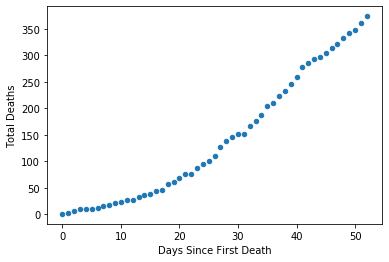

In [114]:
# X: number of deaths
# Y: days since first death

# Pick data from a random county
y = deaths[2969][[deaths[2969] != 0]]
X = [i for i in range(len(y))]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Verifying predictions {} days out".format(len(X_test)))

df = pd.DataFrame({'Days Since First Death': X_train, 'Total Deaths': y_train})
df.plot.scatter(x='Days Since First Death', y='Total Deaths');

# Erf regression

$$ y_i = \beta_0 + \beta_1 erf(\beta_2x - \beta_3) + \epsilon_i$$

$$ \epsilon_i \sim N(0, \sigma) $$

There are five unknowns, each of which need to be given a prior:

$$\beta_0, \beta_1, \beta_2, \beta_3 \sim \text{Normal}(0, 50)$$

$$\sigma \sim \text{HalfNormal}(50)$$

In [115]:
with pm.Model() as covid_model:
    
    β = pm.Normal('β', mu=0, sigma=50, shape=4)
    σ = pm.HalfNormal('σ', sigma=50)
    
    μ = β[0] + (β[1] * pm.math.erf((X_train * β[2]) - β[3]))
    
    pred = pm.Normal('deaths', mu=μ, sigma=σ, observed=y_train)

In [126]:
with covid_model:
    erf_trace = pm.sample(5000, tune=2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β]
Sampling 2 chains, 29 divergences: 100%|██████████| 14000/14000 [01:08<00:00, 205.28draws/s]
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.719061382103403, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


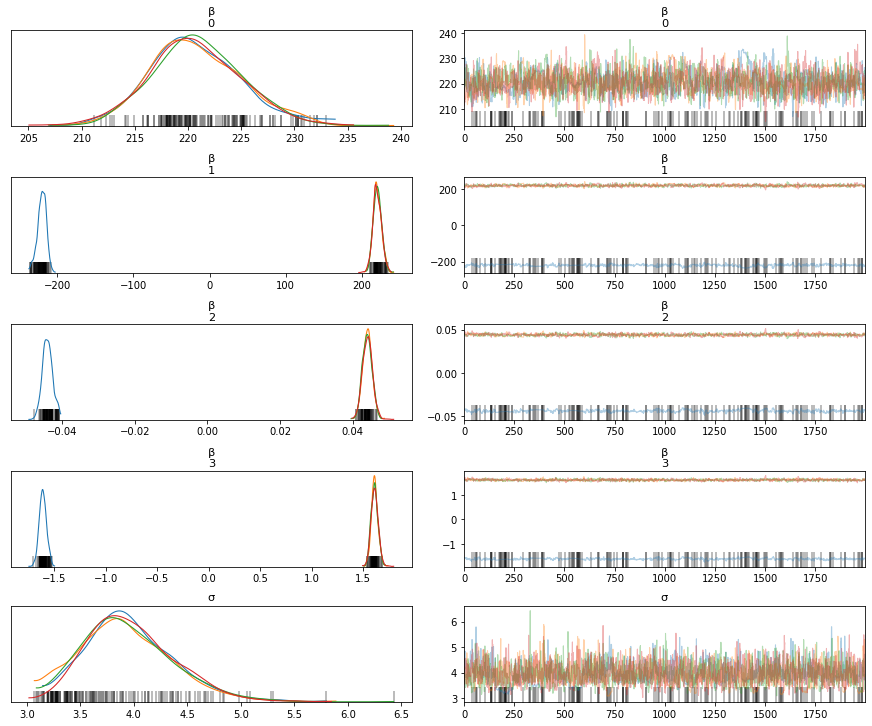

In [124]:
az.plot_trace(erf_trace);

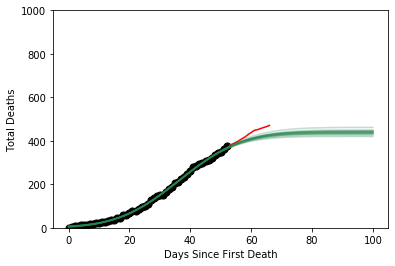

In [125]:
X_pred = np.linspace(0, 100, 100)

ax = df.plot.scatter(x='Days Since First Death', y='Total Deaths', c='k', s=50)
ax.plot(X_test, y_test, color='red')
ax.set_ylim(0, 1000)
for b0,b1,b2,b3 in erf_trace['β'][:50]:
    y = [(b0 + (b1 * math.erf((x * b2) - b3))) for x in X_pred]
    ax.plot(X_pred, y, alpha=0.1 ,color='seagreen');